<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

Цель проекта - подобрать тип и параметры модели для определения цены автомобиля по характеристикам, указанным в объявлении.

Задачи:
1. Собрать актуальные объявления с сайта auto.ru
2. Обработать тренировочный и тестовый датасеты перед их объединением.
3. Поработать с дубликатами, пропусками.
4. Провести EDA
5. Сделать Feature Engineering
6. Перебрать регресоры из разных библиотек и выбрать лучший.
7. Провести подбор оптимальных параметров моделей.
8. Применить бэггинг, стэкинг и ансамблирование моделей.

Для работы собраны данные с сайта auto.ru. В наборе данных следующие признаки:
* body_type - тип кузова,
* brand - марка автомобиля,
* car_url - url страницы объявления
* color - цвет автомобиля,
* engine_displacement - объём двигателя,
* engine_volume - мощность двигателя,
* fuel_type - тип топлива,
* mileage - пробег,
* model_date - дата релиза модели,
* name - имя, введенное пользователем
* number_of_doors - количество дверей,
* production_date - дата производства автомобиля
* vehicle_configuration - конфигурация транспортного средства (ТС),
* vehicle_transmoission - тип коробки передач,
* owners_qty - количество владельцев,
* licence - паспорт ТС,
* type_of_drive - тип привода,
* steering_wheel - сторона руля,
* customs - этап растаможки,
* price - цена автомобиля, целевой параметр,
* sample - индикатор принадлежности данных к тесту (0) и трейну (1),

Часть признаков оказалась малоинформативной и от их использования я отказался в ходе EDA и при подготовке модели.

# IMPORTS, DATA & SETUP

Авторский парсер, адаптированный под запуск в Google Colab - https://github.com/Segodnya/data-science-studies/tree/master/module_6/auto_ru_parser

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import gc

from datetime import datetime

from wordcloud import WordCloud, STOPWORDS 
import string
from nltk.util import ngrams
from collections import Counter

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def get_boxplot(df, col):
    # draw a boxplot
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='price_log', y=col, data=df, ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()


def getFeaturesInfo(df):
    # num of unique values, first 10 unique values, null values count, type
    df_agg = df.agg({'nunique', lambda s: s.unique()[:10]})\
        .append(pd.Series(df.isnull().sum(), name='null'))\
        .append(pd.Series(df.dtypes, name='dtype'))\
        .transpose()

    return df_agg


def getOwningMonths(string):
    # returns the number of months from string value
    line = string.split()
    owning_month = 0
    
    if len(line) > 2:
        owning_month += 12 * float(line[0])
        owning_month += float(line[3])
    else:
        if 'год' in line[1] or 'лет' in line[1]:
            owning_month += 12 * float(line[0])
        else:
            owning_month += float(line[0])

    return owning_month


def calc_delta_ouned(x):
    if x['year'] > 0:
        return (2020 - x['year'])*12 - x['month'] + 9
    else: return 0


VERSION    = 20
DIR_TRAIN  = '../input/autoru-moscow-2021-08/'
DIR_TRAIN_OLD  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20
RANDOM_SEED = 42
USD_TRAIN = 73.2781 # 31.08.2021
USD_TRAIN_OLD = 75.9645 # 09.09.2020
USD_TEST = 77.78 # 21.10.2020


train = pd.read_csv(DIR_TRAIN+'autoru_moscow_2021_08.csv')
# clean data after parsing
train.drop(columns=train.columns[0], axis=1, inplace=True)
train.drop(train[train['Состояние'] == 'Состояние'].index, inplace=True)

train_old = pd.read_csv(DIR_TRAIN_OLD+'all_auto_ru_09_09_2020.csv')
train_old['model_name'] = train_old['model']
train_old['vendor'] = 0
train_old.drop(['model', 'Комплектация', 'start_date', 'hidden'], axis=1, inplace=True)

test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# rename columns with lower eng letters
for df in [train, train_old, test]:
    df.rename(columns={
    'Владельцы': 'owners', 
    'Владение': 'owning', 
    'ПТС': 'pts', 
    'Привод': 'drive', 
    'Руль': 'wheel', 
    'Состояние': 'status', 
    'Таможня': 'customs'
    }, inplace=True)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [2]:
train.head(3).T

,0,1,2
bodyType,седан,универсал 5 дв.,внедорожник 5 дв.
brand,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/rs_e_tron_...,https://auto.ru/cars/used/sale/audi/rs6/110488...,https://auto.ru/cars/used/sale/audi/sq7/110473...
color,серый,серый,синий
complectation_dict,[],"['cruise-control', 'sport-seats', 'e-adjustmen...","['cruise-control', 'sport-seats', 'multi-wheel..."
description,Внимание Только для клиентов AVILON Автомобили...,Автомобиль новый без пробега Куплен у официаль...,Продаётся моя мечта Авто новое доп оборудовани...
engineDisplacement,LTR,4.0 LTR,4.0 LTR
enginePower,646 N12,600 N12,422 N12
equipment_dict,"{'cruise-control': True, 'asr': True, 'esp': T...",{},"{'roller-blind-for-rear-window': True, 'tinted..."
fuelType,электро,бензин,дизель


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23907 entries, 0 to 23906
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              23903 non-null  object 
 1   brand                 23903 non-null  object 
 2   car_url               23907 non-null  object 
 3   color                 23903 non-null  object 
 4   complectation_dict    23907 non-null  object 
 5   description           23903 non-null  object 
 6   engineDisplacement    23903 non-null  object 
 7   enginePower           23903 non-null  object 
 8   equipment_dict        23903 non-null  object 
 9   fuelType              23903 non-null  object 
 10  image                 23907 non-null  object 
 11  mileage               23903 non-null  object 
 12  modelDate             23903 non-null  float64
 13  model_info            0 non-null      float64
 14  model_name            23903 non-null  object 
 15  name               

In [4]:
getFeaturesInfo(train)

,<lambda>,nunique,null,dtype
bodyType,"[седан, универсал 5 дв., внедорожник 5 дв., ку...",21,4,object
brand,"[AUDI, nan, HONDA, VOLKSWAGEN, BMW, MERCEDES, ...",12,4,object
car_url,[https://auto.ru/cars/used/sale/audi/rs_e_tron...,23907,0,object
color,"[серый, синий, чёрный, белый, бежевый, оранжев...",16,4,object
complectation_dict,"[[], ['cruise-control', 'sport-seats', 'e-adju...",424,0,object
description,[Внимание Только для клиентов AVILON Автомобил...,21117,4,object
engineDisplacement,"[ LTR, 4.0 LTR, 3.0 LTR, 5.2 LTR, 2.9 LTR, 2.0...",52,4,object
enginePower,"[646 N12, 600 N12, 422 N12, 249 N12, 530 N12, ...",297,4,object
equipment_dict,"[{'cruise-control': True, 'asr': True, 'esp': ...",19125,4,object
fuelType,"[электро, бензин, дизель, nan, гибрид, газ]",5,4,object


In [5]:
train_old.head(3).T

,0,1,2
bodyType,Седан,Седан,Универсал 5 дв.
brand,AUDI,AUDI,AUDI
color,040001,EE1D19,0000CC
fuelType,бензин,бензин,бензин
modelDate,1990,1982,1988
name,2.8 MT (174 л.с.) 4WD,1.8 MT (90 л.с.),2.3 MT (136 л.с.) 4WD
numberOfDoors,4,4,5
productionDate,1991,1986,1989
vehicleConfiguration,SEDAN MECHANICAL 2.8,SEDAN MECHANICAL 1.8,WAGON_5_DOORS MECHANICAL 2.3
vehicleTransmission,MECHANICAL,MECHANICAL,MECHANICAL


In [6]:
train_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  drive                 89377 non-null  object 
 15  wheel              

In [7]:
getFeaturesInfo(train_old)

,<lambda>,nunique,null,dtype
bodyType,"[Седан, Универсал 5 дв., Хэтчбек 5 дв. Sportba...",168,1,object
brand,"[AUDI, BMW, CADILLAC, CHERY, CHEVROLET, CHRYSL...",36,0,object
color,"[040001, EE1D19, 0000CC, CACECB, 007F00, FAFBF...",16,0,object
fuelType,"[бензин, дизель, электро, гибрид, универсал, газ]",6,0,object
modelDate,"[1990.0, 1982.0, 1988.0, 1976.0, 1983.0, 1979....",78,1,float64
name,"[2.8 MT (174 л.с.) 4WD, 1.8 MT (90 л.с.), 2.3 ...",4484,1,object
numberOfDoors,"[4.0, 5.0, 3.0, 2.0, nan, 0.0]",5,1,float64
productionDate,"[1991, 1986, 1989, 1993, 1992, 1994, 1987, 198...",80,0,int64
vehicleConfiguration,"[SEDAN MECHANICAL 2.8, SEDAN MECHANICAL 1.8, W...",1860,1,object
vehicleTransmission,"[MECHANICAL, AUTOMATIC, ROBOT, VARIATOR, nan]",4,1,object


In [8]:
test.head(3).T

,0,1,2
bodyType,лифтбек,лифтбек,лифтбек
brand,SKODA,SKODA,SKODA
car_url,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/superb/11...
color,синий,чёрный,серый
complectation_dict,NaN,NaN,"{""id"":""20026336"",""name"":""Ambition"",""available_..."
description,"Все автомобили, представленные в продаже, прох...",ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"Все автомобили, представленные в продаже, прох..."
engineDisplacement,1.2 LTR,1.6 LTR,1.8 LTR
enginePower,105 N12,110 N12,152 N12
equipment_dict,"{""engine-proof"":true,""tinted-glass"":true,""airb...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""tinted-glass"":true,""es..."
fuelType,бензин,бензин,бензин


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [10]:
getFeaturesInfo(test)

,<lambda>,nunique,null,dtype
bodyType,"[лифтбек, внедорожник 5 дв., хэтчбек 5 дв., се...",24,0,object
brand,"[SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...",12,0,object
car_url,[https://auto.ru/cars/used/sale/skoda/octavia/...,34686,0,object
color,"[синий, чёрный, серый, коричневый, белый, пурп...",16,0,object
complectation_dict,"[nan, {""id"":""20026336"",""name"":""Ambition"",""avai...",2364,28268,object
description,"[Все автомобили, представленные в продаже, про...",31732,0,object
engineDisplacement,"[1.2 LTR, 1.6 LTR, 1.8 LTR, 2.0 LTR, 1.4 LTR, ...",55,0,object
enginePower,"[105 N12, 110 N12, 152 N12, 200 N12, 102 N12, ...",315,0,object
equipment_dict,"[{""engine-proof"":true,""tinted-glass"":true,""air...",23705,9996,object
fuelType,"[бензин, дизель, гибрид, электро, газ]",5,0,object


In [11]:
sample_submission.head()

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0


parsing_unixtime - время, когда сделан парсинг страниц (можно указать в начале файла, а не в каждой строке). Например, тестовыая выборка сделана Wed Oct 21 2020)

### Drop Duplicates

In [12]:
train.drop_duplicates(subset=['car_url'], inplace=True)
train_old.drop_duplicates(inplace=True)

### Drop NaN

In [13]:
# удаляем столбцы без диффиренцироиванных признаков
non_unique_cols = ['status', 'priceCurrency', 'customs']
train.drop(columns=non_unique_cols, inplace=True)
train_old.drop(columns=['status', 'customs'], inplace=True)
test.drop(columns=non_unique_cols, inplace=True)

# создадим флаги по записям, для которых отсутствуют сведения
train['owning_empty'] = pd.isna(train['owning']).astype('uint8')
train_old['owning_empty'] = pd.isna(train_old['owning']).astype('uint8')
test['owning_empty'] = pd.isna(test['owning']).astype('uint8')
# fill nans
train['owning'].fillna('0 месяцев', inplace=True)
train_old['owning'].fillna('0 месяцев', inplace=True)
test['owning'].fillna('0 месяцев', inplace=True)

# Пропуск данных о ПТС заполним значением 'Оригинал'
train_old['pts'].fillna('Оригинал', inplace=True)
test['pts'].fillna('Оригинал', inplace=True)

# пропуски во внешнем датасете
train_old['description'].fillna('', inplace=True)

change_owners = [0, 65000, 145000, 1e6] # список км смены владельца
labels = [1, 2, 3]
train_old['mileage_owners'] = pd.cut(train_old['mileage'], bins=change_owners,
                                     labels=labels, include_lowest=True) # добавим вспомогательное поле
train_old['owners'] = train_old['owners'].fillna(train_old['mileage_owners']) # заполним пропуски
train_old.drop('mileage_owners', axis=1, inplace=True) # удалим вспомогательное поле

# drop незаполненные объявления (4 шт)
train.dropna(subset=['owners'], inplace=True)
# drop незаполненные объявления (1 шт)
train_old.dropna(subset=['drive'], inplace=True)


# drop объявления без цены
train.dropna(subset=['price'], inplace=True)
train_old.dropna(subset=['price'], inplace=True)


pd.DataFrame([train.isna().sum(), train_old.isna().sum(), test.isna().sum()], index=['train', 'train_old', 'test']).T

,train,train_old,test
bodyType,0.0,0.0,0.0
brand,0.0,0.0,0.0
car_url,0.0,NaN,0.0
color,0.0,0.0,0.0
complectation_dict,0.0,NaN,28268.0
description,0.0,0.0,0.0
engineDisplacement,0.0,0.0,0.0
enginePower,0.0,0.0,0.0
equipment_dict,0.0,NaN,9996.0
fuelType,0.0,0.0,0.0


# PREPROCESSING & MERGING

Для работы с объединенным датасетом необходимо привести в соответствие значения признаков.

Обработку данных будем вести отдельно для train и test с последующим объединением перед процессом моделирования, поскольку для обучения использовались две выборки, собранные по-разному и в разное время.

In [14]:
# bodyType
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower().split()[0])
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).split('-')[0])
train_old['bodyType'] = train_old['bodyType'].apply(lambda x: str(x).lower().split()[0])
train_old['bodyType'] = train_old['bodyType'].apply(lambda x: str(x).split('-')[0])
test['bodyType'] = test['bodyType'].apply(lambda x: str(x).lower().split()[0])
test['bodyType'] = test['bodyType'].apply(lambda x: str(x).split('-')[0])

bodyType_drop = [item for item in list(test['bodyType'].unique()) if item not in list(train['bodyType'].unique())]
train_old['bodyType'].replace(bodyType_drop, 'other', inplace=True)
test['bodyType'].replace(bodyType_drop, 'other', inplace=True)


# brand
brand_drop = [item for item in list(train_old['brand'].unique()) if item not in list(test['brand'].unique())]
train_old['brand'].replace(brand_drop, 'other', inplace=True)

# delete unsuitable brands
# train_old.drop(train_old.loc[train_old['brand']=='other'].index, inplace=True)

# Create a top brands list (more than 350 ads in Dataset)
# all_brands = train['brand'].value_counts().index
# top_brands_list = train['brand'].value_counts()[train['brand'].value_counts() >= 5].index.tolist()
# brands_drop = list(set(all_brands)-set(top_brands_list))
# train.loc[train['brand'].isin(brands_drop), 'brand'] = 'Other'


# color
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}

train_old['color'] = train_old['color'].map(dict_color)


# engineDisplacement
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))
train['engineDisplacement'].replace(' ', 0.0, inplace=True)
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: float(x))
train['engineDisplacement'].replace(0.0, train['engineDisplacement'].median(), inplace=True)

train_old['engineDisplacement'] = train_old['engineDisplacement'].apply(lambda x: float(x) if len(x) == 3 and x[1] == '.' else 'other')
train_old['engineDisplacement'].replace('other', 0.0, inplace=True)
train_old['engineDisplacement'].replace(0.0, train_old['engineDisplacement'].median(), inplace=True)

test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))
test['engineDisplacement'].replace(' ', 0.0, inplace=True)
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: float(x))


# enginePower
train['enginePower'] = train['enginePower'].apply(lambda x: int(str(x[:-4])))
train_old['enginePower'] = train_old['enginePower'].apply(lambda x: int(x))
test['enginePower'] = test['enginePower'].apply(lambda x: int(str(x[:-4])))


# productionDate
train['productionDate'] = train['productionDate'].apply(lambda x: float(x))
train_old['productionDate'] = train_old['productionDate'].apply(lambda x: float(x))
test['productionDate'] = test['productionDate'].apply(lambda x: float(x))


# mileage
train['mileage'] = train['mileage'].apply(lambda x: int(x.replace(' ', '')[:-2]))

#train['mileage_epmty'] = train['mileage'].mask(train['mileage'] != 1, 0)
#train_old['mileage_epmty'] = train_old['mileage'].mask(train_old['mileage'] == 0, 1)
#train_old['mileage_epmty'] = train_old['mileage_epmty'].mask(train_old['mileage_epmty'] != 1, 0)
#test['mileage_epmty'] = test['mileage'].mask(test['mileage'] != 1, 0)

#train['mileage_epmty'] = train.mileage_epmty * ((2021-train.productionDate) * 20000 + 10000)
#train_old['mileage_epmty'] = train_old.mileage_epmty * ((2020-train_old.productionDate) * 20000 + 10000)
#test['mileage_epmty'] = test.mileage_epmty * ((2020-test.productionDate) * 20000 + 10000)

#train['mileage'] = train['mileage'] + train['mileage_epmty']
#train.drop(['mileage_epmty'], axis=1, inplace=True)
#train_old['mileage'] = train_old['mileage'] + train_old['mileage_epmty']
#train_old.drop(['mileage_epmty'], axis=1, inplace=True)
#test['mileage'] = test['mileage'] + test['mileage_epmty']
#test.drop(['mileage_epmty'], axis=1, inplace=True)


# modelDate
train['modelDate'] = train['modelDate'].apply(lambda x: int(float(x)))
train_old['modelDate'] = train_old['modelDate'].apply(lambda x: int(x))


# model_name
train['model_name'] = train['car_url'].apply(lambda x: x.split('/')[7])
train_old['model_name'] = train_old['model_name'].apply(lambda x: x.lower())
test['model_name'] = test['model_name'].apply(lambda x: x.lower())


# numberOfDoors
train['numberOfDoors'] = train['numberOfDoors'].apply(lambda x: int(float(x)))
train_old['numberOfDoors'] = train_old['numberOfDoors'].apply(lambda x: int(x))


# price
train['price'] = train['price'].apply(lambda x: int(float(x)))

# prices in train_old goes to prices in train
# usd_fixer = USD_TRAIN / USD_TRAIN_OLD
# train_old['price'] = train_old['price'].apply(lambda x: int(x * usd_fixer))

train['price_log'] = np.log(train['price'])
train_old['price_log'] = np.log(train_old['price'])

# vehicleTransmission
train_old['vehicleTransmission'] = train_old['vehicleTransmission'].map({
    'AUTOMATIC':'автоматическая',
    'MECHANICAL':'механическая',
    'ROBOT':'роботизированная',
    'VARIATOR':'вариатор'})


# vendor
vendors_dict = {
    'NISSAN': 'JP',
    'LEXUS': 'JP',
    'MERCEDES': 'DE',
    'BMW': 'DE',
    'VOLKSWAGEN': 'DE',
    'MITSUBISHI': 'JP',
    'TOYOTA': 'JP',
    'SKODA': 'EU',
    'HONDA': 'JP', 
    'AUDI': 'DE',
    'VOLVO': 'EU',
    'INFINITI': 'JP',
    'other': 'unknown'
}

train['vendor'] = train['brand'].map(vendors_dict)
train_old['vendor'] = train_old['brand'].map(vendors_dict)
test['vendor'] = test['brand'].map(vendors_dict)


# owners
owners_train = {
    '3 или более': 3.0,
    '2 владельца': 2.0,
    '1 владелец': 1.0
}

owners_test = {
    '3 или более': 3.0,
    '2\xa0владельца': 2.0,
    '1\xa0владелец': 1.0
}

train.replace({"owners": owners_train}, inplace=True)
test.replace({"owners": owners_test}, inplace=True)
train_old['owners'] = train_old['owners'].apply(lambda x: float(x))


# owning
train['owning'] = train['owning'].apply(lambda x: getOwningMonths(x))
test['owning'] = test['owning'].apply(lambda x: getOwningMonths(x))

df_temp = pd.DataFrame(train_old['owning'])
pattern = re.compile('\d{4}')
df_temp['year'] = df_temp['owning'].apply(lambda x:str(pattern.findall(str(x)))[2:-2])
pattern = re.compile('(\d{1,2})\}$')
df_temp['month'] = df_temp['owning'].apply(lambda x:str(pattern.findall(str(x)))[2:-2])

df_temp['year'] = df_temp['year'].map(lambda x: int(x) if len(x)==4 else 0)
df_temp['month'] = df_temp['month'].map(lambda x: int(x) if len(x)>0 else 0)
df_temp['delta_own'] = df_temp.apply(lambda x: calc_delta_ouned(x), axis=1)
train_old['owning'] = df_temp['delta_own']


# pts
train_old['pts'] = train_old['pts'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})
train_old['pts'].fillna('Оригинал', inplace=True)


# wheel
train_old['wheel'] = train_old['wheel'].map({'RIGHT':'Правый', 'LEFT':'Левый'})


# remove unsuitable data
unused_cols = [
    'car_url',
    'complectation_dict',
    'equipment_dict',
    'image',
    'model_info',
    'parsing_unixtime',
    'sell_id',
    'super_gen',
]

train.drop(columns=unused_cols, axis=1, inplace=True)
test.drop(columns=unused_cols, axis=1, inplace=True)

### Контроль соответствия выборок и объединение тренировочных датасетов

In [15]:
getFeaturesInfo(train)

,<lambda>,nunique,null,dtype
bodyType,"[седан, универсал, внедорожник, купе, лифтбек,...",14,0,object
brand,"[AUDI, HONDA, VOLKSWAGEN, BMW, MERCEDES, NISSA...",12,0,object
color,"[серый, синий, чёрный, белый, бежевый, оранжев...",16,0,object
description,[Внимание Только для клиентов AVILON Автомобил...,20945,0,object
engineDisplacement,"[2.0, 4.0, 3.0, 5.2, 2.9, 2.5, 4.2, 1.4, 2.7, ...",51,0,float64
enginePower,"[646, 600, 422, 249, 530, 610, 340, 408, 503, ...",297,0,int64
fuelType,"[электро, бензин, дизель, гибрид, газ]",5,0,object
mileage,"[203, 40, 8000, 421, 2700, 1300, 50, 4300, 165...",10137,0,int64
modelDate,"[2020, 2019, 2018, 2015, 2017, 2012, 2016, 201...",63,0,int64
model_name,"[rs_e_tron_gt, rs6, sq7, sq8, q7, e_tron_gt, q...",435,0,object


In [16]:
getFeaturesInfo(train_old)

,<lambda>,nunique,null,dtype
bodyType,"[седан, универсал, хэтчбек, кабриолет, купе, л...",15,0,object
brand,"[AUDI, BMW, other, HONDA, INFINITI, LEXUS, MIT...",13,0,object
color,"[чёрный, красный, синий, серебристый, зелёный,...",16,0,object
fuelType,"[бензин, дизель, электро, гибрид, газ]",5,0,object
modelDate,"[1990, 1982, 1988, 1976, 1983, 1979, 1986, 199...",78,0,int64
name,"[2.8 MT (174 л.с.) 4WD, 1.8 MT (90 л.с.), 2.3 ...",4484,0,object
numberOfDoors,"[4, 5, 3, 2, 0]",5,0,int64
productionDate,"[1991.0, 1986.0, 1989.0, 1993.0, 1992.0, 1994....",80,0,float64
vehicleConfiguration,"[SEDAN MECHANICAL 2.8, SEDAN MECHANICAL 1.8, W...",1860,0,object
vehicleTransmission,"[механическая, автоматическая, роботизированна...",4,0,object


In [17]:
getFeaturesInfo(test)

,<lambda>,nunique,null,dtype
bodyType,"[лифтбек, внедорожник, хэтчбек, седан, компакт...",15,0,object
brand,"[SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...",12,0,object
color,"[синий, чёрный, серый, коричневый, белый, пурп...",16,0,object
description,"[Все автомобили, представленные в продаже, про...",31732,0,object
engineDisplacement,"[1.2, 1.6, 1.8, 2.0, 1.4, 1.3, 1.0, 3.6, 1.5, ...",55,0,float64
enginePower,"[105, 110, 152, 200, 102, 150, 90, 180, 220, 122]",315,0,int64
fuelType,"[бензин, дизель, гибрид, электро, газ]",5,0,object
mileage,"[74000, 60563, 88000, 95000, 58536, 172000, 10...",11268,0,int64
modelDate,"[2013, 2017, 2008, 2009, 2016, 2012, 2015, 201...",66,0,int64
model_name,"[octavia, superb, octavia_rs, yeti, kodiaq, ra...",544,0,object


In [18]:
train = train.append(train_old, sort=False).reset_index(drop=True)
del train_old
gc.collect()

80

In [19]:
train.sample(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,price,productionDate,vehicleConfiguration,vehicleTransmission,vendor,owners,owning,pts,drive,wheel,owning_empty,price_log
964,лифтбек,AUDI,белый,Продаю Audi A5 Sportback на полном приводе Иск...,2.0,225,бензин,134000,2011,a5,Audi A5 I (8T) Рестайлинг,5,1540000.0,2015.0,LIFTBACK ROBOT 2.0,роботизированная,DE,3.0,11.0,Оригинал,полный,Левый,0,14.247293
54283,внедорожник,INFINITI,красный,Комплектация Luxe\n\n\nПредложение обновлено 0...,2.0,249,бензин,0,2017,qx50,2.0 CVT (249 л.с.) 4WD,5,3445000.0,2019.0,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JP,1.0,0.0,Оригинал,полный,Левый,1,15.052434
28621,седан,BMW,белый,Только 19 и 20 августа дни онлайн-продаж в Бор...,1.6,184,бензин,0,2018,3er,320i 2.0 AT (184 л.с.),4,3116700.0,2020.0,SEDAN AUTOMATIC 320i,автоматическая,DE,1.0,0.0,Оригинал,задний,Левый,1,14.952285
65637,седан,MITSUBISHI,зелёный,Продaю Лaнcер 9. В хорошeм теxничеcкoм coстoян...,1.3,82,бензин,156000,2005,lancer,1.3 MT (82 л.с.),4,160000.0,2006.0,SEDAN MECHANICAL 1.3,механическая,JP,3.0,0.0,Оригинал,передний,Левый,1,11.982929
76287,хэтчбек,other,оранжевый,"Автомoбиль в poдной кpаске,два владeльца! Mеня...",1.6,120,бензин,138000,2006,207,1.6 AT (120 л.с.),5,300000.0,2007.0,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,unknown,2.0,0.0,Оригинал,передний,Левый,1,12.611538


# EDA

## Pandas Profiling and Basic Info

In [20]:
# profile = train.profile_report()
# profile.to_file('data_report_train.html')

In [21]:
# profile = test.profile_report()
# profile.to_file('data_report_test.html')

In [22]:
train.describe()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,price,productionDate,owners,owning,owning_empty,price_log
count,109093.000000,109093.000000,109093.000000,109093.000000,109093.000000,1.090930e+05,109093.000000,109093.000000,109093.000000,109093.000000,109093.000000
mean,2.005413,179.436912,136798.970640,2008.880661,4.509244,1.421676e+06,2011.121126,2.058739,17.649134,0.664112,13.622774
std,0.778545,88.107209,97854.228225,7.111710,0.669415,1.970254e+06,6.709686,0.861923,34.837667,0.472302,1.035435
min,0.600000,11.000000,0.000000,1904.000000,0.000000,1.600000e+04,1904.000000,1.000000,0.000000,0.000000,9.680344
25%,1.600000,120.000000,67000.000000,2005.000000,4.000000,4.100000e+05,2008.000000,1.000000,0.000000,0.000000,12.923912
50%,1.600000,150.000000,130000.000000,2010.000000,5.000000,7.800000e+05,2012.000000,2.000000,0.000000,1.000000,13.567049
75%,2.000000,218.000000,191537.000000,2014.000000,5.000000,1.690000e+06,2016.000000,3.000000,22.000000,1.000000,14.340239
max,8.200000,800.000000,1000000.000000,2021.000000,5.000000,9.900000e+07,2021.000000,3.000000,513.000000,1.000000,18.410630


In [23]:
test.describe()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,owners,owning,owning_empty
count,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000
mean,2.402255,188.194142,162009.767889,2007.074728,4.450816,2009.264602,2.187338,19.001124,0.654183
std,0.964484,89.087035,100676.559489,7.415894,0.703040,7.047661,0.835266,37.161233,0.475641
min,0.000000,30.000000,1.000000,1904.000000,0.000000,1904.000000,1.000000,0.000000,0.000000
25%,1.800000,125.000000,91153.500000,2004.000000,4.000000,2006.000000,1.000000,0.000000,0.000000
50%,2.000000,169.000000,149779.500000,2008.000000,5.000000,2011.000000,2.000000,0.000000,1.000000
75%,3.000000,233.000000,215000.000000,2012.000000,5.000000,2014.000000,3.000000,24.000000,1.000000
max,6.600000,639.000000,1000000.000000,2020.000000,5.000000,2020.000000,3.000000,514.000000,1.000000


Следующие признаки либо дублируют информацию в прочих, либо содержат значительное количество пропусков, либо не подлежат приведению к единому формату между тестовой и тренировочной выборками:
* complectation_dict
* equipment_dict
* image
* name
* model_info
* super_gen
* vehicleConfiguration (комбинированный признак - тип кузова, количество дверей, тип коробки передач и объем двигателя)

### bodyType

Подавляющее большинство автомобилей - внедорожники и седаны. Семейные и коммерческие авто (компактвэны, фургоны, микровэны, универсалы) в целом дешевле, чем прочие. А вот родстеры, кабриолеты и, особенно, лимузины - дороже.

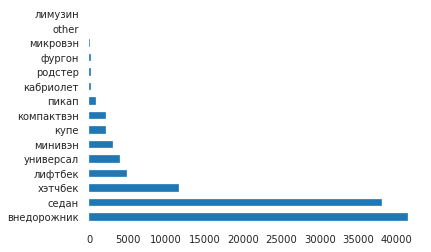

In [24]:
train["bodyType"].value_counts().plot.barh()


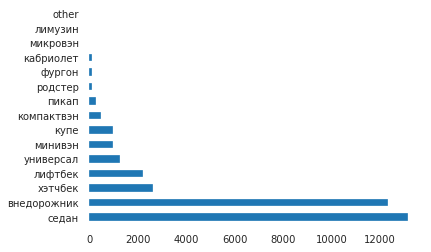

In [25]:
test["bodyType"].value_counts().plot.barh()


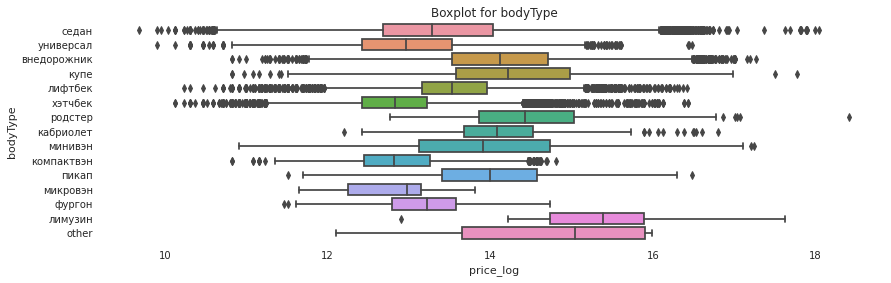

In [26]:
get_boxplot(train, 'bodyType')

### brand

Тренировочный датасет содержит 36 марок. В тестовой выборке только 12: 'SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI', 'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'. Для повышения эффективности модели на тестовом датасете оставим 12 брендов, а оставшиеся объединим в категории "Другие".

Автомобили Мерседес, БМВ и Лексу, в целом, дорогие. Skoda, Honda в данной выборке оказываются бюджетными. В то же время категория "Другие" имеет еще более низкую среднюю цену - в том числе потому, что в ней есть и отечественные, и китайские автомобили.

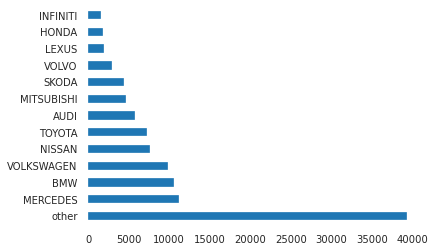

In [27]:
train["brand"].value_counts().plot.barh()

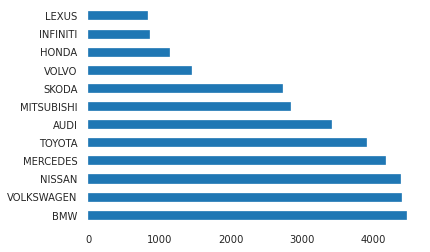

In [28]:
test["brand"].value_counts().plot.barh()

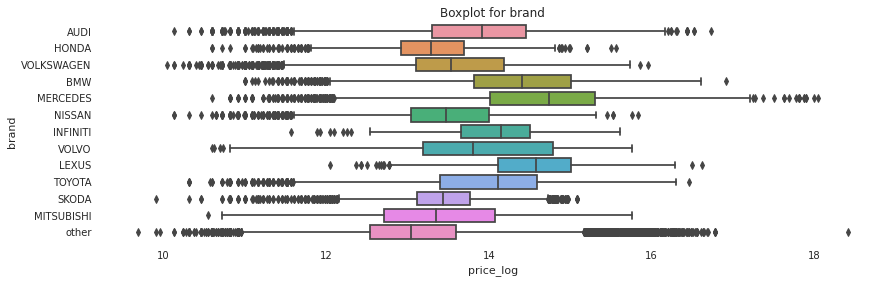

In [29]:
get_boxplot(train, 'brand')

### color

Преобразование признаков не требуется.

Наиболее часто встречающиеся автомобили - черные. Они же и более дорогие. Неожиданно примерно одинаковый разброс и среднюю цену имеют серые, оранжевые и коричневые авто.

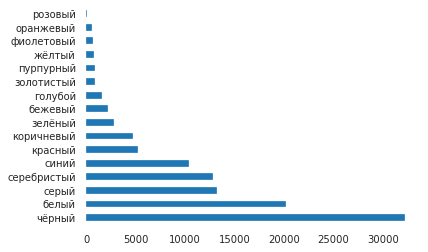

In [30]:
train["color"].value_counts().plot.barh()

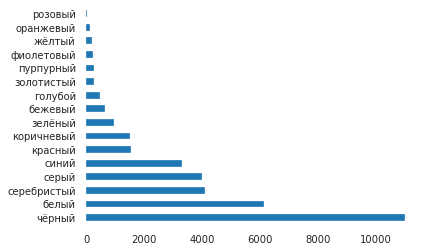

In [31]:
test["color"].value_counts().plot.barh()

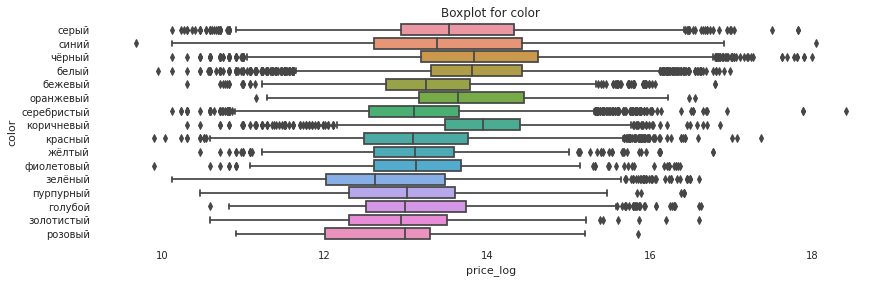

In [32]:
get_boxplot(train, 'color')

### description

Описание технического состояния ТС, выполненное продавцом. Без применения анализа текстов признак не применим.
Анализ и добавление признаков осуществим после объединения датасетов.

In [33]:
# ... 

### engineDisplacement

Требовалось удаление символов 'LTR' в тестовой выборке. Ниже, при проведении корреляционного анализа, будет показано, что признак коррелирует с мощностью двигателя, что ожидаемо.

In [34]:
train['engineDisplacement'].value_counts()

1.6    47121
2.0    18565
1.4     6629
1.8     6440
3.0     4778
       ...  
8.1        1
7.4        1
7.5        1
0.6        1
8.2        1
Name: engineDisplacement, Length: 63, dtype: int64

In [35]:
test['engineDisplacement'].value_counts()

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
4.0     356
3.2     348
4.5     346
2.1     271
3.7     242
2.2     236
4.2     228
1.9     221
2.3     203
2.7     189
3.6     183
5.6     170
5.0     158
5.7     135
2.9     131
4.6     108
3.1      88
4.8      84
1.7      59
1.0      57
3.8      57
2.6      55
0.0      55
6.0      53
0.7      53
3.3      44
3.4      36
4.1      35
4.3      32
5.4      31
6.2      28
5.2      12
5.9      12
6.3       8
5.8       7
6.6       6
1.1       4
4.9       4
3.9       1
5.3       1
Name: engineDisplacement, dtype: int64

### enginePower

Наиболее часто встречаются мощности двигателя в 150 и 249 л.с. На основе enginePower будет построена наивная модель, которая будет предсказывать цену как медиану цен среди автомобилей с аналогичной мощностью двигателя.

In [36]:
train['enginePower'].value_counts()

150    8163
249    5476
140    3379
110    2784
105    2765
       ... 
176       1
700       1
481       1
475       1
403       1
Name: enginePower, Length: 410, dtype: int64

In [37]:
test['enginePower'].value_counts()

249    1708
150    1699
110    1039
170     977
105     955
       ... 
38        1
485       1
324       1
164       1
32        1
Name: enginePower, Length: 315, dtype: int64

### fuelType - преобразование не требуется

Подавляющее большинство автомобилей - бензиновые. Доля гибридов, электрических и на газу незначительна. Электрические автомобиле выставляются по ценам выше рынка, в то время как газовые - ниже (однако, выборки по этим категориям небольшие, и вероятно, что нерепрезентативны).

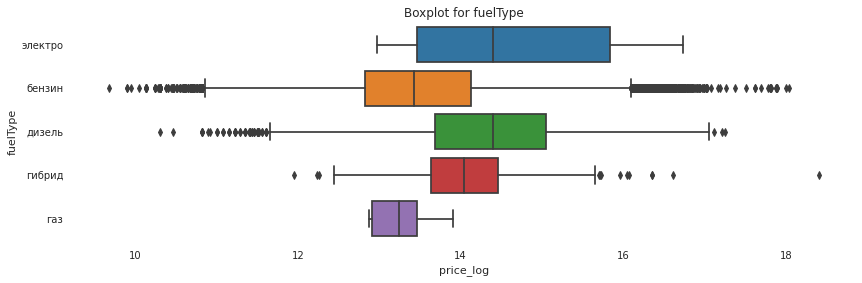

In [38]:
get_boxplot(train, 'fuelType')

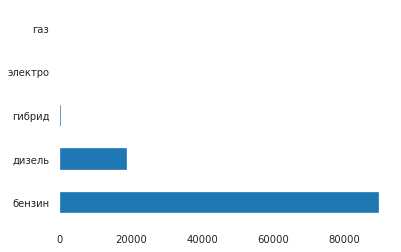

In [39]:
train["fuelType"].value_counts().plot.barh()

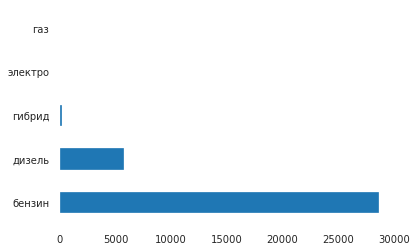

In [40]:
test["fuelType"].value_counts().plot.barh()

### productionDate

В выборках есть один автомобиль 1904 года. В то же время, наибольшее количество автомобилей - автомобили возрастом 8-10 лет.

In [41]:
pd.DataFrame([train.productionDate.describe(), test.productionDate.describe()])

,count,mean,std,min,25%,50%,75%,max
productionDate,109093.0,2011.121126,6.709686,1904.0,2008.0,2012.0,2016.0,2021.0
productionDate,34686.0,2009.264602,7.047661,1904.0,2006.0,2011.0,2014.0,2020.0


### mileage

TODO: Deal with 1km-mileage

In [42]:
display(len(train[train.mileage==1]))
display(len(test[test.mileage==1]))

31

11

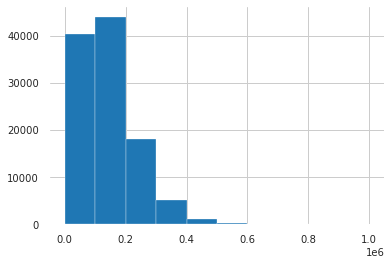

In [43]:
train['mileage'].sort_values().hist()

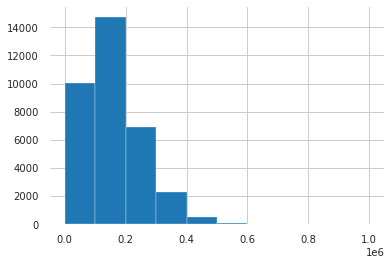

In [44]:
test['mileage'].sort_values().hist()

### modelDate

Дата производства и дата выпуска модели в свет - признаки коррелирующиеся, но на их основе в дальнейшем введем признак "Время, в течение которого модель находится на рынке" (жизненный цикл модели).

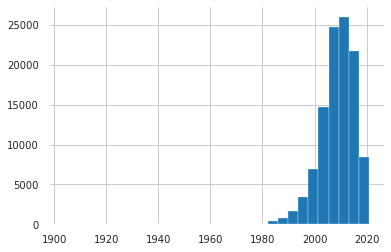

In [45]:
train['modelDate'].sort_values().hist(bins=30)

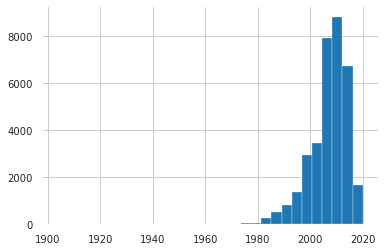

In [46]:
test['modelDate'].sort_values().hist(bins=30)

In [47]:
# модели до 1980 года
display(len(train[train.modelDate < 1980]))
display(len(test[test.modelDate < 1980]))

274

116

### model_name

Признак будет использован при создании новых признаков - редкость модели, ассортимент автомобильного бренда.

In [48]:
train['model_name'].value_counts()

focus       2455
5er         2309
octavia     2233
e_klasse    1985
polo        1814
            ... 
taro           1
admiral        1
freda          1
m1             1
orion          1
Name: model_name, Length: 1127, dtype: int64

In [49]:
test['model_name'].value_counts()

octavia            1418
5er                1026
lancer              855
e_klasse            809
passat              782
                   ... 
lancer_ralliart       1
presea                1
granvia               1
slc_klasse            1
atlas                 1
Name: model_name, Length: 544, dtype: int64

### numberOfDoors

In [50]:
train['numberOfDoors'].value_counts()

5    63553
4    40352
2     2807
3     2380
0        1
Name: numberOfDoors, dtype: int64

In [51]:
train[train['numberOfDoors'] == 0].T

,107806
bodyType,кабриолет
brand,MERCEDES
color,белый
description,"на ходу. 1904 год. стоит в гараже, пылится.Кат..."
engineDisplacement,5.3
enginePower,32
fuelType,бензин
mileage,48000
modelDate,1904
model_name,simplex


In [52]:
test['numberOfDoors'].value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [53]:
test[test['numberOfDoors'] == 0].T

,16944
bodyType,кабриолет
brand,MERCEDES
color,белый
description,"на ходу. 1904 год. стоит в гараже, пылится.Кат..."
engineDisplacement,5.3
enginePower,32
fuelType,бензин
mileage,48000
modelDate,1904
model_name,simplex


### price

Значения целевой переменной имеют высокий разброс. Для улучшения модели при работе с такими данными будут полезны логарифмирование, работа с выбросами и стандартизация.

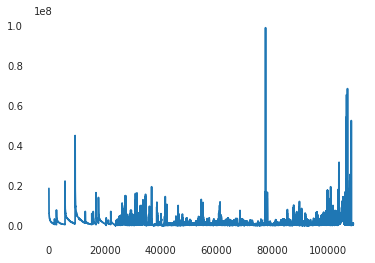

In [54]:
train.price.plot()

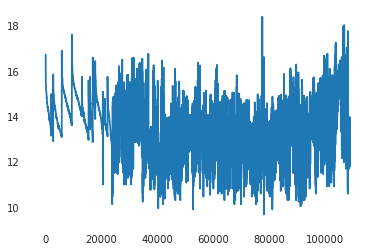

In [55]:
train.price_log.plot()

In [56]:
train['price'].sort_values()

78303        16000.0
52851        20000.0
81228        20000.0
40353        21000.0
91356        23000.0
             ...    
106695    59087576.0
106691    59087576.0
106687    65435792.0
107014    68500000.0
77645     99000000.0
Name: price, Length: 109093, dtype: float64

### vehicleTransmission

Автомобилей на механической коробке - четверть тренировочного датасета. И они, в целом, значительно дешевле прочих. В то время как средний уровень цен и размах для автомобилей с автоматическими, роботизированными КПП и вариаторами практически идентичный.

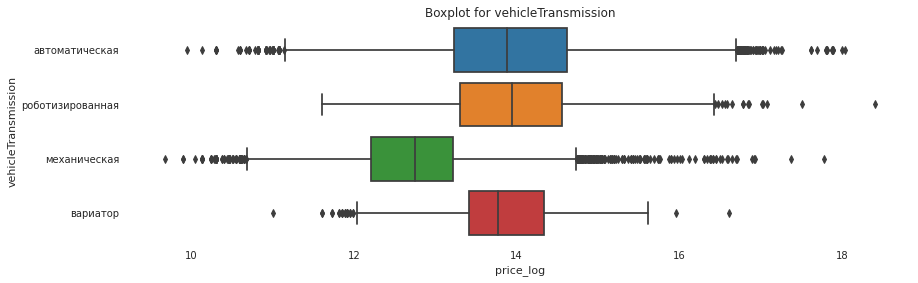

In [57]:
get_boxplot(train, 'vehicleTransmission')

In [58]:
train['vehicleTransmission'].value_counts()

автоматическая      62197
механическая        27166
роботизированная    10806
вариатор             8924
Name: vehicleTransmission, dtype: int64

In [59]:
test['vehicleTransmission'].value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

### vendor

Подтверждается то, что мы видели при анализе распределения цен по брендам производителей. немецкий автомобили - самые дорогие. Европейские (за исключением немецких) - дешевле японских.

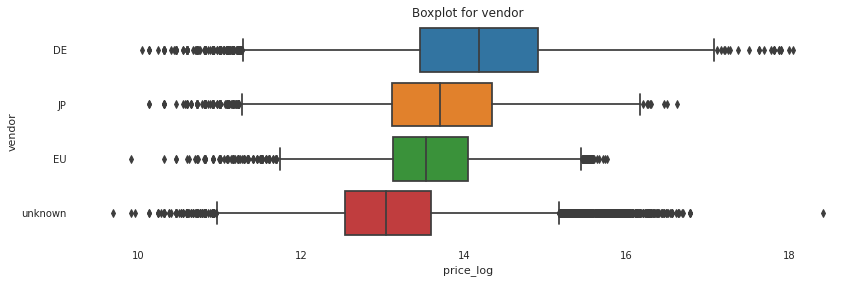

In [60]:
get_boxplot(train, 'vendor')

In [61]:
train['vendor'].value_counts()

unknown    39265
DE         37503
JP         24949
EU          7376
Name: vendor, dtype: int64

In [62]:
test['vendor'].value_counts()

DE    16478
JP    14004
EU     4204
Name: vendor, dtype: int64

### owners

In [63]:
# Учитывая зависимость пробега и количество владельцев,
# посчитал среднее значение владельцев в зависимости от пробега.
# Отсюда можно выделить 3 переломных цифры,когда в среднем владелец меняется.
bins = np.arange(0, 170000, 10000)
train.groupby(pd.cut(train.mileage, bins)).owners.median()

mileage
(0, 10000]          1.0
(10000, 20000]      1.0
(20000, 30000]      1.0
(30000, 40000]      1.0
(40000, 50000]      1.0
(50000, 60000]      1.0
(60000, 70000]      2.0
(70000, 80000]      2.0
(80000, 90000]      2.0
(90000, 100000]     2.0
(100000, 110000]    2.0
(110000, 120000]    2.0
(120000, 130000]    2.0
(130000, 140000]    2.0
(140000, 150000]    3.0
(150000, 160000]    3.0
Name: owners, dtype: float64

In [64]:
train['owners'].value_counts()

3.0    43915
1.0    37507
2.0    27671
Name: owners, dtype: int64

In [65]:
test['owners'].value_counts()

3.0    15957
1.0     9459
2.0     9270
Name: owners, dtype: int64

### owning

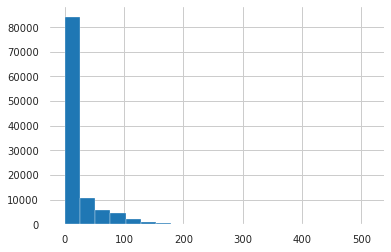

In [66]:
train['owning'].sort_values().hist(bins=20)

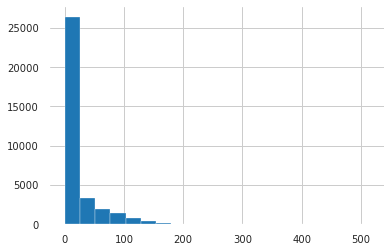

In [67]:
test['owning'].sort_values().hist(bins=20)

In [68]:
# more than 10 years with one owner
display(len(train[train.owning > 120]))
display(len(test[test.owning > 120]))

2624

995

### pts

Отсутствие оригинала ПТС серьезно влияет на цену в объявлении. Отличный бинарный признак.

In [69]:
pts_duplicates = (len(train[train.pts == 'Дубликат']) + len(test[test.pts == 'Дубликат'])) / (len(train) + len(test))
print('Процент автомобилей с дубликатом ПТС:', round(100*pts_duplicates, 2))

Процент автомобилей с дубликатом ПТС: 11.99


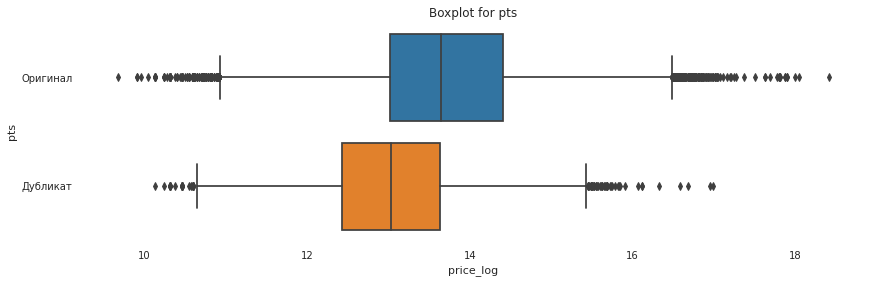

In [70]:
get_boxplot(train, 'pts')

### drive

При учете того, что общая доля количества полноприводных и переднеприводных автомобилей отличаются незначительно (и это наиболее популярные категории), разброс цен между ними существенный и в пользу полноприводных автомобилей.

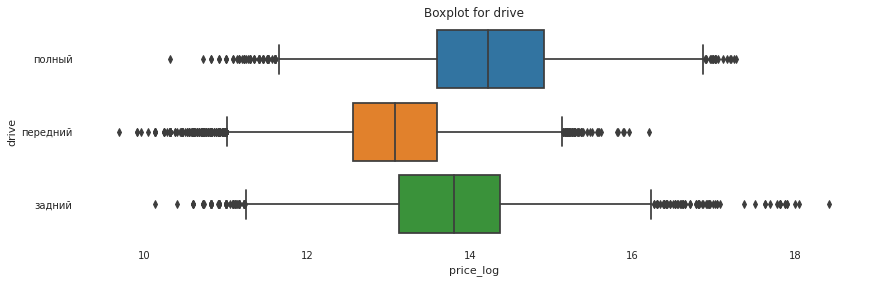

In [71]:
get_boxplot(train, 'drive')

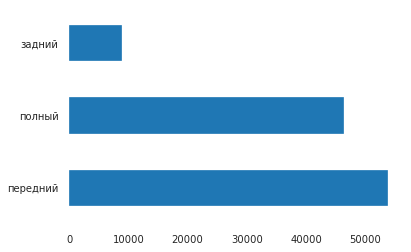

In [72]:
train["drive"].value_counts().plot.barh()

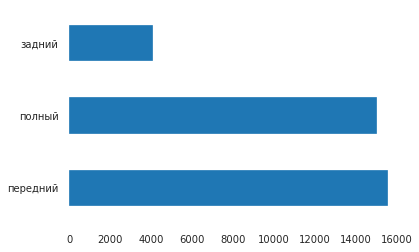

In [73]:
test["drive"].value_counts().plot.barh()

### wheel

Праворульных автомобилей мало и, как правило, они дешевле.

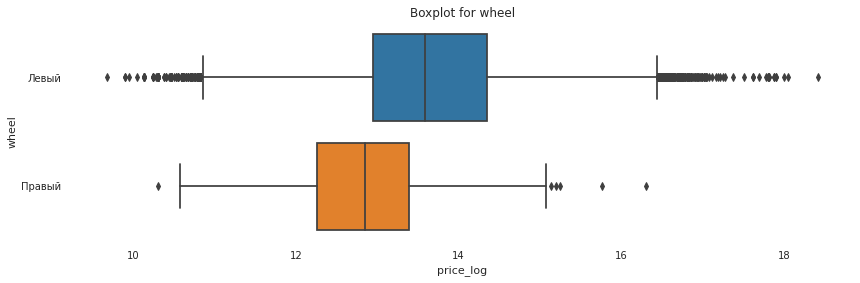

In [74]:
get_boxplot(train, 'wheel')

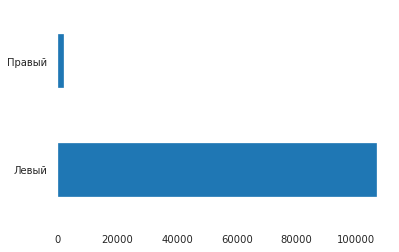

In [75]:
train["wheel"].value_counts().plot.barh()

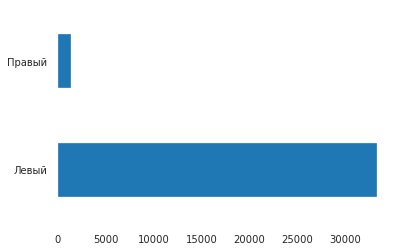

In [76]:
test["wheel"].value_counts().plot.barh()

# FEATURE ENGINEERING

При получении данных об объявлениях с сайта можно дополнительно получать информацию, например, о регионе, в котором размещено объявление, а также количестве просмотров объявления. Тем не менее, в тестовой выборке эти сведения отсутствуют, потому парсинг по этим позициям не осуществлялся.

### brand model range

Количество моделей в линейке автопроизводителя

In [77]:
brand_range_dict = dict(train.groupby('brand')['model_name'].nunique())
train['brand_range'] = train['brand'].map(brand_range_dict)
brand_range_dict = dict(test.groupby('brand')['model_name'].nunique())
test['brand_range'] = test['brand'].map(brand_range_dict)


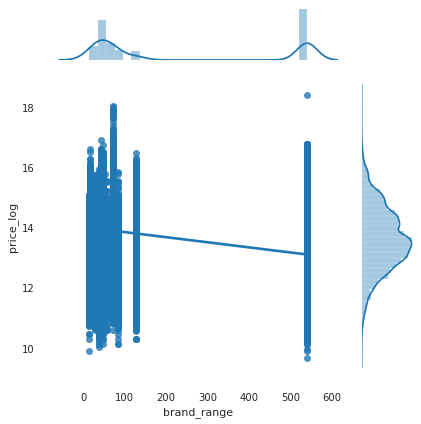

In [78]:
sns.jointplot(x='brand_range', y='price_log', data=train, kind='reg')

### brand rarity

Редкость (или популярность) конкретной марки автомобиля.

In [79]:
brand_rar_dict = dict(train['brand'].value_counts() / len(train))
train['brand_pop'] = train['brand'].map(brand_rar_dict)
brand_rar_dict = dict(test['brand'].value_counts() / len(test))
test['brand_pop'] = test['brand'].map(brand_rar_dict)


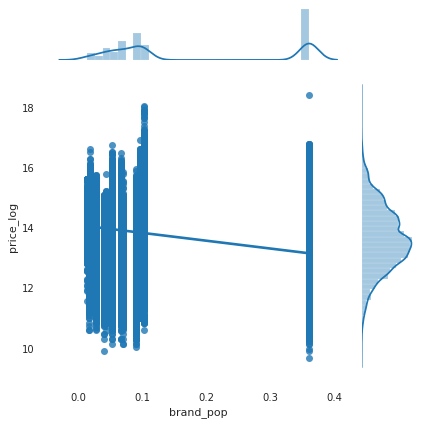

In [80]:
sns.jointplot(x='brand_pop', y='price_log', data=train, kind='reg')

### model rarity

Редкость (или популярность) конкретной модели автомобиля из объявления.

In [81]:
model_rar_dict = dict(train['model_name'].value_counts() / len(train))
train['model_pop'] = train['model_name'].map(model_rar_dict)
model_rar_dict = dict(test['model_name'].value_counts() / len(test))
test['model_pop'] = test['model_name'].map(model_rar_dict)


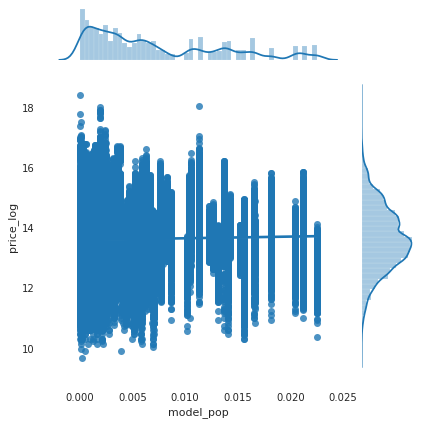

In [82]:
sns.jointplot(x='model_pop', y='price_log', data=train, kind='reg')

### model_in_brand

Признак комбинирует в себе широу ассортимента автопроизводителя и популярность конкретной модели.

Не прошел проверку на мультиколлинеарность

In [83]:
#train['model_cars_count'] = train['model_name'].apply(lambda x: train['model_name'].value_counts()[x])
#train['brand_cars_total'] = train['brand'].apply( lambda x: train.groupby('brand')['model_name'].value_counts()[x].sum())
#train['model_in_brand'] = train['model_cars_count'] / train['brand_cars_total']
#train.drop(['model_cars_count', 'brand_cars_total'], axis=1, inplace=True)

#test['model_cars_count'] = test['model_name'].apply(lambda x: test['model_name'].value_counts()[x])
#test['brand_cars_total'] = test['brand'].apply( lambda x: test.groupby('brand')['model_name'].value_counts()[x].sum())
#test['model_in_brand'] = test['model_cars_count'] / test['brand_cars_total']
#test.drop(['model_cars_count', 'brand_cars_total'], axis=1, inplace=True)


### model_age

Возраст модели (не конкретного автомобиля).

Не прошел проверку на мультиколлинеарность

In [84]:
#train['model_age'] = 2021 - train['modelDate']
#test['model_age'] = 2021 - test['modelDate']


### car_age

Преобразование даты производства в возраст автомобиля.

In [85]:
train['car_age'] = 2021 - train['productionDate']
test['car_age'] = 2021 - test['productionDate']


# Разобьем возраст на интервалы
# bins = [0, 3, 6, 13, 20, 35, 120]
# numbers = ['3', '6','13','20','35', '116']

# train['age_intervals'] = pd.cut(train['car_age'],bins, labels=numbers)
# test['age_intervals'] = pd.cut(test['car_age'], bins, labels=numbers)

### prod_epoch

Период, в течение которого производилась конкретная модель.

In [86]:
train['prod_epoch'] = train['productionDate'] - train['modelDate']
test['prod_epoch'] = test['productionDate'] - test['modelDate']

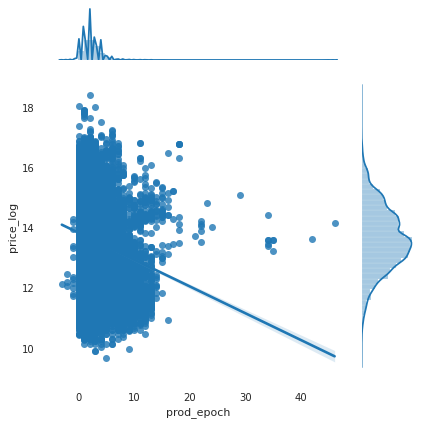

In [87]:
sns.jointplot(x='prod_epoch', y='price_log', data=train, kind='reg')

### seller type

Определение типа продавца по ключевым словам из описания. Два флага - собственник и автосалон.

In [88]:
train['description'] = train['description'].map(lambda x: str(x).lower())

train['owner'] = train['description'].apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<200 else 0)
train['showroom'] = train['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                               or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                               or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(train['owner'].value_counts())
display(train['showroom'].value_counts())

0    55329
1    53764
Name: owner, dtype: int64

0    70093
1    39000
Name: showroom, dtype: int64

In [89]:
test['description'] = test['description'].map(lambda x: str(x).lower())

test['owner'] = test['description'].apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<200 else 0)
test['showroom'] = test['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                             or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                             or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(test['owner'].value_counts())
display(test['showroom'].value_counts())

0    17826
1    16860
Name: owner, dtype: int64

0    23134
1    11552
Name: showroom, dtype: int64

### Collections, Sport

Создадим несколько бинарных признаков исходя из модели, которые на практике сильно влияют на стоимость автомобиля:

* collector - коллекционные автомобили
* sport - спортивные автомобили

In [90]:
# список коллекционных марок (из машин произведеных до 1960 года )
collector = list(train.query('productionDate<1980').model_name.value_counts().keys())
# список спортивных марок(из моделей которые в среднем имеют мощность более 500 л.с.)
sport = list(train.groupby('model_name').enginePower.mean().sort_values(ascending=False)[:25].keys())
# закодируем
for value, models in {'collector': collector, 'sport': sport}.items():
    mask = train['model_name'].isin(models)
    train[value] = mask*1
    
    
# список коллекционных марок (из машин произведеных до 1960 года )
collector = list(test.query('productionDate<1980').model_name.value_counts().keys())
# список спортивных марок(из моделей которые в среднем имеют мощность более 500 л.с.)
sport = list(test.groupby('model_name').enginePower.mean().sort_values(ascending=False)[:25].keys())
# закодируем
for value, models in {'collector': collector, 'sport': sport}.items():
    mask = test['model_name'].isin(models)
    test[value] = mask*1

### description analysis

TODO: Word2Vec

Создадим из описания(description) несколько числовых признаков:

* количество символов из описания (description_length)
* повторяемость объявлений (repeat_description)

In [91]:
train['description_length'] = train['description'].map(lambda x: len(x))

dict_count_description = train['description'].value_counts().loc[lambda x: x > 2].to_dict()
train['repeat_description'] = train['description'].map(dict_count_description)
train['repeat_description'].fillna(1, inplace=True)


test['description_length'] = test['description'].map(lambda x: len(x))

dict_count_description = test['description'].value_counts().loc[lambda x: x > 2].to_dict()
test['repeat_description'] = test['description'].map(dict_count_description)
test['repeat_description'].fillna(1, inplace=True)

Проведем анализа текста объявлений на предмет частоты встречаемости конкретных словосочетаний и сформируем несколько признаков на основе ключевых слов.

In [92]:
text = ' '.join(train['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(30)
my_list

[(('', '', '', '', ''), 32543),
 (('-', '-', '-', '-', '-'), 10150),
 (('подушки', 'безопасности', 'водителя\n•', 'подушки', 'безопасности'), 4803),
 (('иммобилайзер\n•', 'центральный', 'замок\n•', 'бортовой', 'компьютер\n•'),
  4678),
 (('крепления', 'детских', 'автокресел', 'isofix', '/'), 4589),
 (('система', 'крепления', 'детских', 'автокресел', 'isofix'), 4571),
 (('детских', 'автокресел', 'isofix', '/', 'latch\n•'), 4562),
 (('центральный', 'замок\n•', 'бортовой', 'компьютер\n•', 'круиз-контроль\n•'),
  4064),
 (('безопасности', 'водителя\n•', 'подушки', 'безопасности', 'пассажира\n•'),
  3894),
 (('система', 'помощи', 'при', 'старте', 'в'), 3798),
 (('подогрев', 'сидений', 'водителя', 'и', 'пассажира\n•'), 3757),
 (('литые', 'легкосплавные', 'диски\n•', 'размер', 'дисков'), 3534),
 (('боковые', 'зеркала', 'заднего', 'вида', 'с'), 3450),
 (('безопасности\n•', 'система', 'крепления', 'детских', 'автокресел'), 3435),
 (('количество', 'мест:', '5\n•', 'тип', 'сидений:'), 3316),
 (('

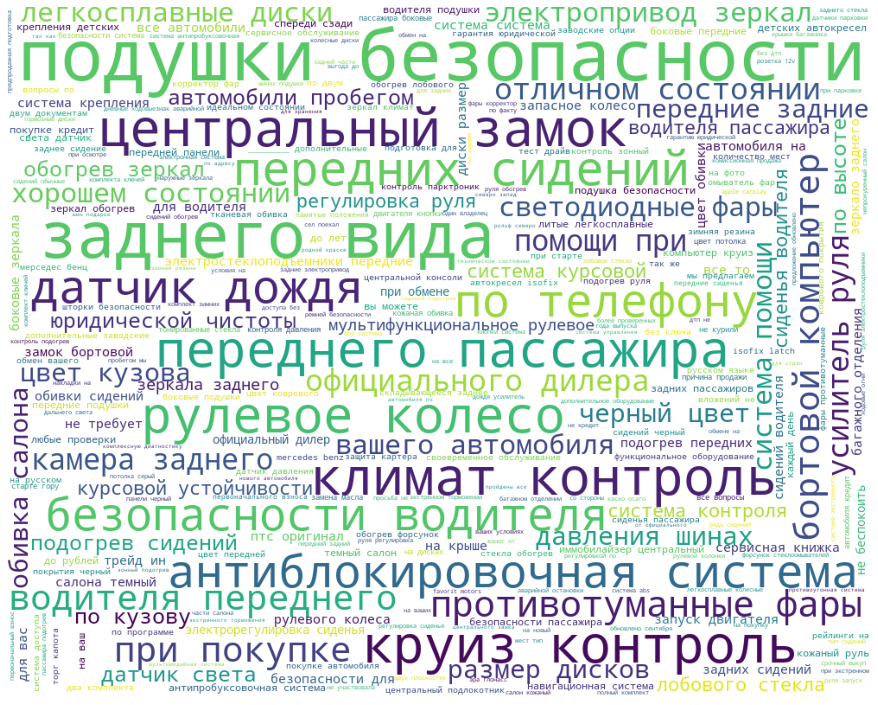

In [93]:
comment_words = '' 
stopwords = set(STOPWORDS) 
newStopWords = ['автомобиль', 'продаю', 'автомобилей', 'пробег']
stopwords.update(newStopWords)

  
# iterate through the csv file 
for val in train.description: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens)+" "
    

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(train['description'].astype(str)))

# plot the WordCloud image                        
plt.figure(figsize = (12, 14), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [94]:
text = ' '.join(test['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(30)
my_list

[(('', '', '', '', ''), 19450),
 (('иммобилайзер\n•', 'центральный', 'замок\n•', 'бортовой', 'компьютер\n•'),
  1059),
 (('электростеклоподъемники', 'передние', 'и', 'задние\n•', 'электропривод'),
  1025),
 (('передние', 'и', 'задние\n•', 'электропривод', 'зеркал\n•'), 1023),
 (('обмен', 'вашего', 'автомобиля', 'на', 'новый'), 983),
 (('крепления', 'детских', 'автокресел', 'isofix', '/'), 976),
 (('-', 'обмен', 'вашего', 'автомобиля', 'на'), 972),
 (('вашего', 'автомобиля', 'на', 'новый', 'или'), 972),
 (('автомобиля', 'на', 'новый', 'или', 'с'), 972),
 (('подогрев', 'сидений', 'водителя', 'и', 'пассажира\n•'), 972),
 (('система', 'крепления', 'детских', 'автокресел', 'isofix'), 970),
 (('детских', 'автокресел', 'isofix', '/', 'latch\n•'), 969),
 (('подушки', 'безопасности', 'водителя\n•', 'подушки', 'безопасности'), 961),
 (('юридической', 'чистоты', 'в', 'соответствии', 'с'), 957),
 (('центральный', 'замок\n•', 'бортовой', 'компьютер\n•', 'круиз-контроль\n•'),
  938),
 (('безопасност

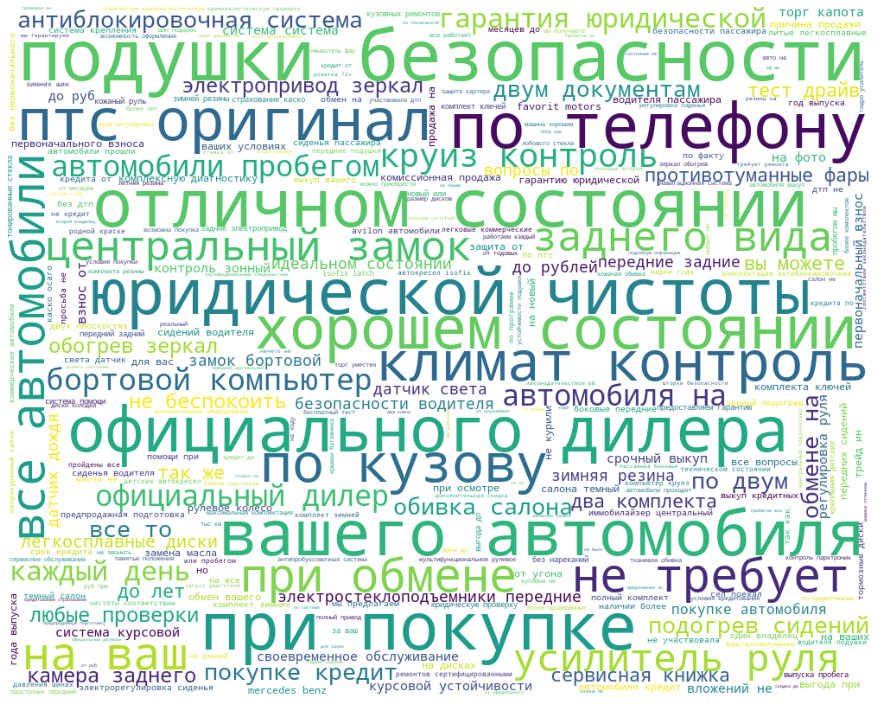

In [95]:
comment_words = '' 
stopwords = set(STOPWORDS) 
newStopWords = ['автомобиль', 'продаю', 'автомобилей', 'пробег']
stopwords.update(newStopWords)

  
# iterate through the csv file 
for val in test.description: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    
    
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(test['description'].astype(str)))

# plot the WordCloud image                        
plt.figure(figsize = (12, 14), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [96]:
# under comments - multi-high-corr-features

# train['is_pillows'] = train.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
# test['is_pillows'] = test.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)

# train['is_wheelsup'] = train.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
# test['is_wheelsup'] = test.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)

train['is_great'] = train.description.apply(lambda x: 1 if 'отличном состоянии' in x else 0)
test['is_great'] = test.description.apply(lambda x: 1 if 'отличном состоянии' in x else 0)

train['is_good'] = train.description.apply(lambda x: 1 if 'хорошем состоянии' in x else 0)
test['is_good'] = test.description.apply(lambda x: 1 if 'хорошем состоянии' in x else 0)

# train['is_ckey'] = train.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
# test['is_ckey'] = test.description.apply(lambda x: 1 if 'центральный замок' in x else 0)

# train['is_elecwindow'] = train.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
# test['is_elecwindow'] = test.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)

# train['is_pc'] = train.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
# test['is_pc'] = test.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)

train['is_climate'] = train.description.apply(lambda x: 1 if 'климат контроль' in x else 0)
test['is_climate'] = test.description.apply(lambda x: 1 if 'климат контроль' in x else 0)

train['is_cruise'] = train.description.apply(lambda x: 1 if 'круиз контроль' in x else 0)
test['is_cruise'] = test.description.apply(lambda x: 1 if 'круиз контроль' in x else 0)

train['is_antiblock'] = train.description.apply(lambda x: 1 if 'антиблокировочная система' in x else 0)
test['is_antiblock'] = test.description.apply(lambda x: 1 if 'антиблокировочная система' in x else 0)


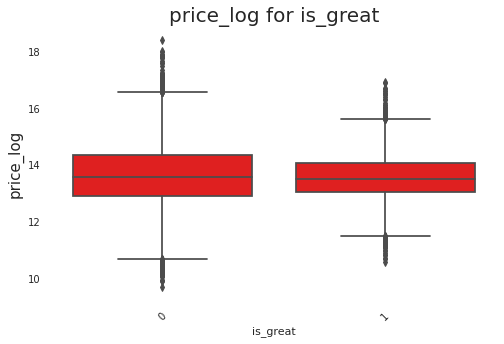

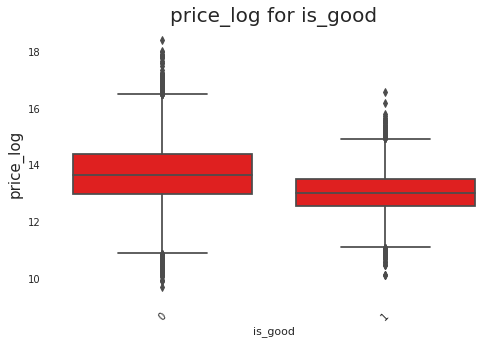

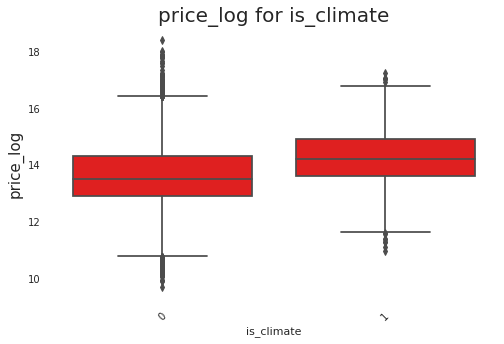

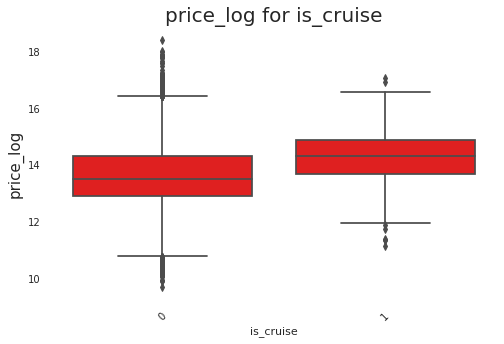

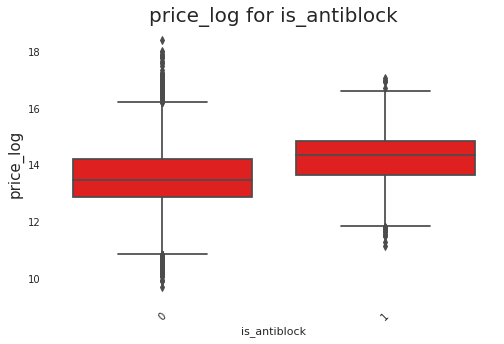

In [97]:
equip = [ 'is_great', 'is_good',
          'is_climate', 'is_cruise', 'is_antiblock']

for eq in equip:
    plt.figure(figsize=(8, 5))
    g1 = sns.boxplot(y='price_log', x=eq, 
                      data=train, color='red')
    g1.set_title(f"price_log for {eq}", fontsize=20)

    g1.set_ylabel("price_log", fontsize=15)
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()

### tax_rate

Попытка добавить признак, характеризующий налоговое бремя, которое будет возложено на автовладельца после приобретения машины.

In [98]:
# unsuitable due to high multi-corr with enginePower
# show bigger MAPE against using enginePower-feature

# Разобьем мощность на интервалы
# bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
# numbers = ['5000','12','25','35', '45', '50', '65', '75', '150']

# налоговая база
# train['tax_base'] = pd.cut(train['enginePower'], bins, labels=numbers)
# test['tax_base'] = pd.cut(test['enginePower'], bins, labels=numbers)
# train['tax_base'] = train['tax_base'].values.astype('int64')
# test['tax_base'] = test['tax_base'].values.astype('int64')

# train['tax'] = train['enginePower'] * train['tax_base']
# test['tax'] = test['enginePower'] * test['tax_base']

Попытка неудачная - признак сильно коррелирует с мощностью двигателя, при этом статистическая значимость мощности двигателя при проверке оказалась выше.

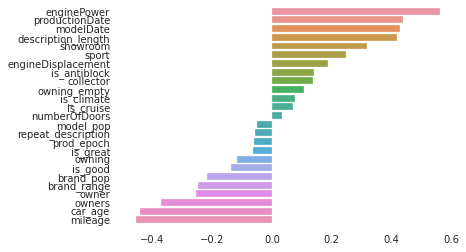

In [99]:
# Посмотрим наибольшие корреляционные связи с  переменной price
all_cols = set(train.columns) - set(['price', 'price_log'])
correlations = train[all_cols].corrwith(train['price']).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)

# LABEL ENCODING

In [100]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

# drop surplus features (come later to analyze them) 
surplus_cols = [
    'description',
    'model_name',
    'name',
    'vehicleConfiguration',
    'modelDate',
    'productionDate',
    'price_log'
]

data.drop(surplus_cols, axis=1, inplace=True)

y = train['price'].values

del [[train, test]]
gc.collect()

cat_cols = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'vehicleTransmission',
    'vendor',
    'owners',
    'pts',
    'drive',
    'wheel'
]

for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes
    
getFeaturesInfo(data)

,<lambda>,nunique,null,dtype
bodyType,"[6, 1, 14, 11, 3, 12, 9, 4, 2, 8]",15,0,int8
brand,"[8, 0, 2, 11, 1, 7, 3, 5, 9, 4]",13,0,int8
color,"[13, 15, 12, 6, 1, 9, 0, 11, 7, 4]",16,0,int8
engineDisplacement,"[1.2, 1.6, 1.8, 2.0, 1.4, 1.3, 1.0, 3.6, 1.5, ...",64,0,float64
enginePower,"[105, 110, 152, 200, 102, 150, 90, 180, 220, 122]",410,0,int64
fuelType,"[0, 3, 2, 4, 1]",5,0,int8
mileage,"[74000, 60563, 88000, 95000, 58536, 172000, 10...",31942,0,int64
numberOfDoors,"[5, 4, 2, 3, 0]",5,0,int64
vehicleTransmission,"[3, 2, 0, 1]",4,0,int8
vendor,"[1, 0, 2, 3]",4,0,int8


### Feature Importance

TODO: Fix memory leaks in Binary Features Importance Script

In [101]:
data_temp = data.loc[data['sample'] == 1].drop(['sample'], axis=1)

In [102]:
num_cols = [
    'engineDisplacement',
    'enginePower',
    'mileage',
    'numberOfDoors',
    'owning',
    'brand_range',
    'brand_pop',
    'model_pop',
    'prod_epoch',
    'car_age',
    'description_length',
    'repeat_description'
]

bin_cols = [
    'pts',
    'wheel',
    'owning_empty',
    'owner',
    'showroom',
    'collector', 'sport',
    'is_great', 'is_good',
    'is_climate', 'is_cruise', 'is_antiblock'
]

cat_cols = [
    'bodyType',
    'brand',
    'color',
    'owners',
    'fuelType',
    'vehicleTransmission',
    'vendor',
    'drive'
]

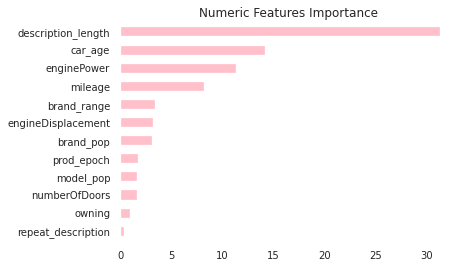

In [103]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh', color='pink', title='Numeric Features Importance')

In [104]:
imp_num

repeat_description     0.347671
owning                 0.896525
numberOfDoors          1.555663
model_pop              1.556776
prod_epoch             1.707987
brand_pop              3.065277
engineDisplacement     3.186137
brand_range            3.398309
mileage                8.138430
enginePower           11.319848
car_age               14.195751
description_length    31.313864
dtype: float64

In [105]:
#for part in [bin_cols_1, bin_cols_2, bin_cols_3]:
#    imp_bin = pd.Series(mutual_info_classif(data_temp[part], data_temp['price'], discrete_features=False), index=part)
#    imp_bin.sort_values(inplace=True)
#    imp_bin.plot(kind='barh', color='pink', title='Binary Features Importance')
#    display(imp_bin)
#    del [imp_bin]
#    gc.collect()

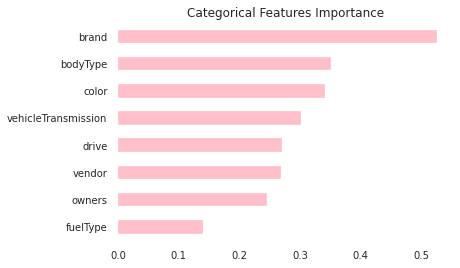

In [106]:
imp_cat = pd.Series(mutual_info_classif(
    data_temp[cat_cols],
    data_temp['price'],
    discrete_features=True
), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', color='pink', title='Categorical Features Importance')

In [107]:
imp_cat

fuelType               0.140463
owners                 0.245632
vendor                 0.268602
drive                  0.270862
vehicleTransmission    0.301159
color                  0.340758
bodyType               0.351389
brand                  0.525792
dtype: float64

### Выбросы и стандартизация

In [108]:
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Column: ", col)
    print(' 25%: {:.4},\n'.format(perc25), '75%: {:.4},\n'.format(perc75),
          "IQR: {:.4}, \n".format(IQR), "Borderline: [{f:.4}, {l:.4}].\n".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()
    
    # replace outliers with border-values
    data[col] = np.where(data[col] > (perc75 + 1.5*IQR), (perc75 + 1.5*IQR), data[col])
    data[col] = np.where(data[col] < (perc25 - 1.5*IQR), (perc25 - 1.5*IQR), data[col])

Column:  engineDisplacement
 25%: 1.6,
 75%: 2.4,
 IQR: 0.8, 
 Borderline: [0.4, 3.6].


Column:  enginePower
 25%: 122.0,
 75%: 221.0,
 IQR: 99.0, 
 Borderline: [-26.5, 369.5].


Column:  mileage
 25%: 7.35e+04,
 75%: 1.98e+05,
 IQR: 1.245e+05, 
 Borderline: [-1.132e+05, 3.848e+05].


Column:  numberOfDoors
 25%: 4.0,
 75%: 5.0,
 IQR: 1.0, 
 Borderline: [2.5, 6.5].


Column:  owning
 25%: 0.0,
 75%: 22.0,
 IQR: 22.0, 
 Borderline: [-33.0, 55.0].


Column:  brand_range
 25%: 39.0,
 75%: 540.0,
 IQR: 501.0, 
 Borderline: [-712.5, 1.292e+03].


Column:  brand_pop
 25%: 0.07022,
 75%: 0.3599,
 IQR: 0.2897, 
 Borderline: [-0.3643, 0.7945].


Column:  model_pop
 25%: 0.002356,
 75%: 0.01316,
 IQR: 0.01081, 
 Borderline: [-0.01386, 0.02937].


Column:  prod_epoch
 25%: 1.0,
 75%: 3.0,
 IQR: 2.0, 
 Borderline: [-2.0, 6.0].


Column:  car_age
 25%: 5.0,
 75%: 14.0,
 IQR: 9.0, 
 Borderline: [-8.5, 27.5].


Column:  description_length
 25%: 165.0,
 75%: 1.005e+03,
 IQR: 840.0, 
 Borderline: [-1.

In [109]:
# scaler = StandardScaler() less effective
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)

### Get Dumies

In [110]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

### Correlation Matrix

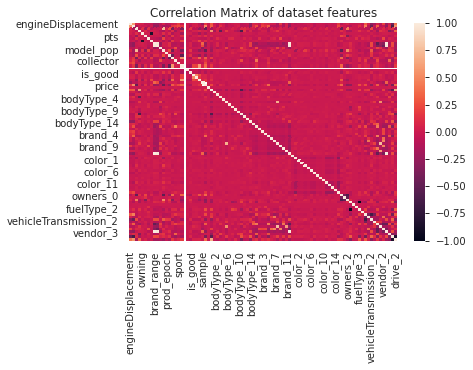

In [111]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot = False)

In [112]:
# show features with corr > 0.7
corr = data.corr().abs()
corr_table = corr.unstack()
corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
high_corr = corr_exclude_ones[corr_exclude_ones >= 0.7]
high_corr

brand_12      brand_range     0.992650
brand_range   vendor_3        0.992650
              brand_12        0.992650
vendor_3      brand_range     0.992650
fuelType_3    fuelType_0      0.976474
fuelType_0    fuelType_3      0.976474
brand_pop     vendor_3        0.975766
brand_12      brand_pop       0.975766
brand_pop     brand_12        0.975766
vendor_3      brand_pop       0.975766
brand_pop     brand_range     0.974306
brand_range   brand_pop       0.974306
owning        owning_empty    0.863052
owning_empty  owning          0.863052
drive_1       drive_2         0.833363
drive_2       drive_1         0.833363
brand_8       vendor_1        0.772022
vendor_1      brand_8         0.772022
car_age       mileage         0.747164
mileage       car_age         0.747164
brand_8       bodyType_6      0.707287
bodyType_6    brand_8         0.707287
dtype: float64

In [113]:
# exclude features due high corr and low importance
data.drop([
    'vendor_3', 'brand_12', 'fuelType_3',
    'brand_pop', 'drive_2', 'brand_8', 'owning_empty', 'repeat_description'
], axis=1, inplace=True)

### Query

In [114]:
X = data.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample', 'price'], axis=1)

## Train Split

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Models

### Naive Model

Создадим "наивную" модель. Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [116]:
# tmp_train = X_train.copy()
# tmp_train['price'] = y_train

# Находим median по экземплярам enginePower в трейне и размечаем тест
# predict = X_test['enginePower'].map(tmp_train.groupby('enginePower')['price'].median())

# оцениваем точность
# print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# MAPE: 62.67%

### CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [117]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                           )
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True)

# model.save_model('catboost_single_model_baseline.model')
# 
# оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# MAPE: 16.04%

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [118]:
# np.log(y_train)

In [119]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                           )
# model.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True)

# model.save_model('catboost_single_model_2_baseline.model')

# predict_test = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# MAPE: 12.89%

## ПОДБОР ПАРАМЕТРОВ

### CatBoost Regressor

In [120]:
#start = datetime.now()
#
#model = CatBoostRegressor(iterations=50,
#                          loss_function='MAPE',
#                          metric_period=10)
#
#grid = {'learning_rate': [ 0.13, 0.14, 0.15],
#        'depth': [12],
#        'l2_leaf_reg': [7, 7.5, 8],
#        'random_strength': [0.3]}
#
#grid_search_result = model.grid_search(grid,
#                                       X=X_train,
#                                       y=np.log(y_train),
#                                       verbose=False)
#
#print('\nВремя выполнения - ', datetime.now() - start)
#print('\nНаилучшие параметры: ', grid_search_result['params'])

In [121]:
# cb = CatBoostRegressor(iterations = 5000,
#                        random_seed = RANDOM_SEED,
#                        eval_metric='MAPE',
#                        custom_metric=['R2', 'MAE'],
#                        silent=True,
#                        learning_rate=0.15, depth=12,
#                        l2_leaf_reg=7.5, random_strength=0.3)

# cb.fit(X_train, np.log(y_train),
#        eval_set=(X_test, np.log(y_test)),
#        verbose=False,
#        use_best_model=True)

# cb.save_model('catboost_log_model.model')

# оцениваем точность
# predict_cb = np.exp(cb.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_cb))*100:0.2f}%")

# MAPE: 12.88%

### LGBM Regressor

In [122]:
lgbmr = LGBMRegressor(objective='regression', max_depth=12, num_leaves=1000,
                      learning_rate=0.02, n_estimators=22000, metric='mape',
                      feature_fraction=0.6)

lgbmr.fit(X_train, np.log(y_train))

# оцениваем точность
predict_lgbmr = np.exp(lgbmr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbmr))*100:0.2f}%")

# MAPE: 12.89%

Точность модели по метрике MAPE: 12.89%


In [123]:
# TODO

# from sklearn.model_selection import GridSearchCV

# lgbmr = LGBMRegressor(objective='regression', metric='mape', feature_fraction=0.6, random_state=RANDOM_SEED)

# params = {
#     'num_leaves': [10, 25, 50, 100, 250],
#     'learning_rate': [0.01, 0.1, 1.0],
#     'max_depth': [-1, 3, 7, 9, 13],
#     'n_estimators': [50, 100, 500, 1000],
#     'boosting_type': ['gbdt', 'dart', 'goss']
# }

# grid = GridSearchCV(lgbmr, params, scoring='neg_mean_absolute_error', cv=5)
# grid.fit(X_train, y_train)

# print(grid.best_estimator_)
# print(grid.best_params_)

In [124]:
# start = datetime.now()

# bagg_lgbm = BaggingRegressor(lgbmr, n_estimators=3, n_jobs=4, random_state=RANDOM_SEED)
# bagg_lgbm.fit(X_train, np.log(y_train))
# predict_bagg_lgbm = np.exp(bagg_lgbm.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagg_lgbm))*100:0.2f}%")

### Random Forest

In [125]:
#start = datetime.now()
#
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#               'max_features': ['auto', 'sqrt'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}
#
#rfr = RandomForestRegressor(random_state = RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator = rfr,
#                               param_distributions = random_grid,
#                               n_iter = 100,
#                               cv = 3,
#                               verbose=10,
#                               random_state=RANDOM_SEED,
#                               n_jobs=4)
#
#rf_random.fit(X_train, np.log(y_train))
#print(rf_random.best_params_)
#print('\nВремя выполнения - ', datetime.now() - start)


In [126]:
# best_rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                                  n_estimators=200,
#                                  min_samples_split=2,
#                                  min_samples_leaf=2,
#                                  max_features='auto',
#                                  max_depth=None,
#                                  bootstrap=True)

# best_rfr.fit(X_train, np.log(y_train))

# оцениваем точность
# predict_rfr = np.exp(best_rfr.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rfr))*100:0.2f}%")

# MAPE: 13.39%

### Gradient Boosting Regressor

In [127]:
#start = datetime.now()
#
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4]}

#gbr = GradientBoostingRegressor()
#gbr_random = RandomizedSearchCV(estimator = gbr,
#                                param_distributions = random_grid,
#                                n_iter = 100,
#                                cv = 3,
#                                verbose=10,
#                                random_state=RANDOM_SEED,
#                                n_jobs=4)

#gbr_random.fit(X_train, np.log(y_train))
#print(gbr_random.best_params_)
#print('\nВремя выполнения - ', datetime.now() - start)


In [128]:
# best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                      n_estimators=400,
#                                      min_samples_split=5,
#                                      min_samples_leaf=2,
#                                      max_features='auto',
#                                      max_depth=9)

# best_gbr.fit(X_train, np.log(y_train))

# оцениваем точность
# predict_gbr = np.exp(best_gbr.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_gbr))*100:0.2f}%")

# MAPE: 12.89%

### XGB Regressor

In [129]:
# start = datetime.now()

# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
#                            colsample_bytree=0.5,
#                            learning_rate=0.05,
#                            max_depth=12,
#                            alpha=1,
#                            n_estimators=1000)

# xgb_reg.fit(X_train, np.log(y_train))

# оцениваем точность
# predict_xgb = np.exp(xgb_reg.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_xgb))*100:0.2f}%")
# print('\nВремя выполнения - ', datetime.now() - start)

# MAPE: 12.54%

## BAGGING

### Random Forest

In [130]:
# start = datetime.now()

# bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=4, random_state=RANDOM_SEED)
# bagg_rfr.fit(X_train, np.log(y_train))
# predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagg_rfr))*100:0.2f}%")
# print('\nВремя выполнения - ', datetime.now() - start)

# MAPE: 13.62%

### Gradient Boosting

In [131]:
# start = datetime.now()

# bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=4, random_state=RANDOM_SEED)
# bagg_gbr.fit(X_train, np.log(y_train))
# predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagg_gbr))*100:0.2f}%")

# MAPE: 12.89%

### XGBoost

In [132]:
# start = datetime.now()

# bagg_xgb = BaggingRegressor(xgb_reg, n_estimators=3, n_jobs=4, random_state=RANDOM_SEED)
# bagg_xgb.fit(X_train, np.log(y_train))
# predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")
# print('\nВремя выполнения - ', datetime.now() - start)

# MAPE: 12.69%

## Stacking & Ensembles

In [133]:
# start = datetime.now()

# estimators = [('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                                                    n_estimators=400,
#                                                                    min_samples_split=5,
#                                                                    min_samples_leaf=2,
#                                                                    max_features='auto',
#                                                                    max_depth=9),
#                                          n_estimators=3,
#                                          n_jobs=4,
#                                          random_state=RANDOM_SEED)),
#               ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
#                                        colsample_bytree=0.5,
#                                        learning_rate=0.05,
#                                        max_depth=12,
#                                        alpha=1,
#                                        n_estimators=1000))]

# st_ensemble = StackingRegressor(estimators=estimators,
#                                 final_estimator = CatBoostRegressor(iterations = 5000,
#                                                                     random_seed = RANDOM_SEED,
#                                                                     eval_metric='MAPE',
#                                                                     custom_metric=['R2', 'MAE'],
#                                                                     silent=True,
#                                                                     learning_rate=0.13,
#                                                                     depth=12,
#                                                                     l2_leaf_reg=7.5,
#                                                                     random_strength=0.3))

    
# st_ensemble.fit(X_train, np.log(y_train))

# predict_ensemble = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")
# print('\nВремя выполнения - ', datetime.now() - start)

# MAPE: 12.93%

Осуществлен перебор регрессионных моделей из разных библиотек. Сделан подбор параметров. Попробован бэггинг и стэкинг, ансамбли моделей. Результаты экспериментов записаны в виде метрик под лучшими вариантами моделей и испробованы на тестовом датасете на каггле (перфоманс моделей на тестовом датасете - ниже).

### Lazy Predict

In [134]:
# !pip install lazypredict 

In [135]:
# from lazypredict.Supervised import LazyRegressor

# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

# SUBMISSION

In [136]:
# sample_submission['price'] = predict_submission
# sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
# Kaggle MAPE 19.19103

# train-dollar prices goes to test-dollar prices
# usd_fixer = USD_TRAIN / USD_TEST
# sample_submission['price'] = predict_submission * usd_fixer
# sample_submission.to_csv(f'submission_2_v{VERSION}_currency_correct.csv', index=False)
# Kaggle MAPE 17.26228

# round to nearest 5000 rub price w/ dollar-changing pattern
# usd_fixer = USD_TRAIN / USD_TEST
# sample_submission['price'] = np.round(predict_submission * usd_fixer,-3).astype('int')
# sample_submission.to_csv(f'submission_2_v{VERSION}_currency_correct_round.csv', index=False)
# Kaggle MAPE 17.26256

# catboost
# predict_test = np.exp(cb.predict(X_sub))
# sample_submission['price'] = predict_test
# sample_submission.to_csv(f'submission_CB_v{VERSION}.csv', index=False)
# Kaggle MAPE 18.00332

# LGBM Regressor
# predict_lgbmr = np.exp(lgbmr.predict(X_sub))
# sample_submission['price'] = predict_lgbmr
# sample_submission.to_csv(f'submission_LGBMR_v{VERSION}.csv', index=False)
# Kaggle MAPE 16.83216

# LGBM Regressor with currency fixer
usd_fixer = USD_TRAIN / USD_TEST
predict_lgbmr = np.exp(lgbmr.predict(X_sub))
sample_submission['price'] = predict_lgbmr * usd_fixer
sample_submission.to_csv(f'submission_LGBMR_v{VERSION}_currency_correct.csv', index=False)
# Kaggle MAPE 15.18838

# random forest
# predict_rfr = np.exp(best_rfr.predict(X_sub))
# sample_submission['price'] = predict_rfr
# sample_submission.to_csv(f'submission_RFR_v{VERSION}.csv', index=False)
# Kaggle MAPE 17.41994

# grad boosting
# predict_gbr = np.exp(best_gbr.predict(X_sub))
# sample_submission['price'] = predict_gbr
# sample_submission.to_csv(f'submission_GBR_v{VERSION}.csv', index=False)
# Kaggle MAPE 18.33223

# xgboost
# xgb_reg_pred = np.exp(xgb_reg.predict(X_sub))
# sample_submission['price'] = xgb_reg_pred
# sample_submission.to_csv(f'submission_XGB_v{VERSION}.csv', index=False)
# Kaggle MAPE 17.28800

# xgboost with currency fixer
# usd_fixer = USD_TRAIN / USD_TEST
# xgb_reg_pred = np.exp(xgb_reg.predict(X_sub))
# sample_submission['price'] = xgb_reg_pred * usd_fixer
# sample_submission.to_csv(f'submission_XGB_v{VERSION}_currency_correct.csv', index=False)
# Kaggle MAPE 15.83164

# bagging random forest
# predict_bagg_rfr = np.exp(bagg_rfr.predict(X_sub))
# sample_submission['price'] = predict_bagg_rfr
# sample_submission.to_csv(f'submission_bagRF_v{VERSION}.csv', index=False)
# Kaggle MAPE 17.09522

# bagging random forest with currency fixer
# usd_fixer = USD_TRAIN / USD_TEST
# predict_bagg_rfr = np.exp(bagg_rfr.predict(X_sub))
# sample_submission['price'] = predict_bagg_rfr * usd_fixer
# sample_submission.to_csv(f'submission_bagRF_v{VERSION}_currency_correct.csv', index=False)
# Kaggle MAPE

# bagging grad boosting
# predict_bagg_gbr = np.exp(bagg_gbr.predict(X_sub))
# sample_submission['price'] = predict_bagg_gbr
# sample_submission.to_csv(f'submission_bagGBR_v{VERSION}.csv', index=False)
# Kaggle MAPE 17.86295

# bagging xgboost
# predict_bagg_xgb = np.exp(bagg_xgb.predict(X_sub))
# sample_submission['price'] = predict_bagg_xgb
# sample_submission.to_csv(f'submission_bagXGB_v{VERSION}.csv', index=False)
# Kaggle MAPE 17.10128

# bagging xgboost with currency fixer
# usd_fixer = USD_TRAIN / USD_TEST
# predict_bagg_xgb = np.exp(bagg_xgb.predict(X_sub))
# sample_submission['price'] = predict_bagg_xgb * usd_fixer
# sample_submission.to_csv(f'submission_bagXGB_v{VERSION}_currency_correct.csv', index=False)
# Kaggle MAPE 15.61873

# stacking and ensembling
# predict_ensemble = np.exp(st_ensemble.predict(X_sub))
# sample_submission['price'] = predict_ensemble
# sample_submission.to_csv(f'submission_st_Ens_v{VERSION}.csv', index=False)
# Kaggle MAPE 18.35810

В итоге получили **MAPE 15.18838** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

В целом, по завершении проекта делаю вывод о том, что наибольший прирост в качестве модели получается засчет скармливания новых данных. Больше данных - точнее модель. При этом нужно учитывать количество ресурсов (вычислительных, временных) на сбор и обработку данных, расчет и моделирование.

# TODO

1. Изучть как можно использовать обработку изображений и информации с них для улучшения модели.
2. Deal with 1km-mileage
3. Replace EngineDisplacement=0 with groupped medians of EnginePower
4. LGMBR + GridSearchCV для n_estimators >>> 1000. Bagging for Best-LGMBR.
5. Stacking для LGBMR с параметрами, RandomForrestRegressor с параметрами и XGBoost с параметрами.